<img title="GitHub Octocat" src='./img/Octocat.jpg' style='height: 60px; padding-right: 15px' alt="Octocat" align="left"> This notebook is part of a GitHub repository: https://github.com/pessini/moby-bikes 
<br>MIT Licensed
<br>Author: Leandro Pessini

# <p style="font-size:100%; text-align:left; color:#444444;">Models</p>

# <p style="font-size:100%; text-align:left; color:#444444;">Table of Contents:</p>
* [1. Datasets](#1)
  * [1.1 Rentals Data - Moby Bikes](#1.1)
  * [1.2 Weather Data - Met Éireann](#1.2)
* [2. Preprocessing & Feature Engineering](#2)
  * [2.1 Target variable distribution](#2.1)
  * [2.2 Missing values](#2.2)
  * [2.3 Exploratory Analysis](#2.3)
  * [2.4 Features Importance](#2.4)

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
import sys
import os

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models & Evaluation
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# statsmodel
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
import statsmodels.stats as stats

# Boost models
import xgboost as xgb
from xgboost import XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
import catboost as cat
from catboost import CatBoostRegressor

from sklearn import metrics

# Hyperparameter optimization
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Custom objects
sys.path.insert(0, os.path.abspath('../src/'))
import experiment_tracker as et

import time
import warnings
warnings.simplefilter('ignore', FutureWarning)
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [38]:
df_train = pd.read_csv('../data/processed/df_train.csv')
df_test = pd.read_csv('../data/processed/df_test.csv')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   rain                8760 non-null   float64
 1   temp                8760 non-null   float64
 2   rhum                8760 non-null   int64  
 3   wdsp                8760 non-null   int64  
 4   date                8760 non-null   object 
 5   hour                8760 non-null   int64  
 6   day                 8760 non-null   int64  
 7   month               8760 non-null   int64  
 8   year                8760 non-null   int64  
 9   count               8760 non-null   int64  
 10  holiday             8760 non-null   bool   
 11  dayofweek_n         8760 non-null   int64  
 12  dayofweek           8760 non-null   object 
 13  working_day         8760 non-null   bool   
 14  season              8760 non-null   object 
 15  peak                8760 non-null   bool   
 16  timeso

> Example of dynamic table with evalution metrics: https://www.kirenz.com/post/2021-12-06-regression-splines-in-python/regression-splines-in-python/

## Splitting data in train and test set

In [39]:
# # OrdinalEnconder
# enc_rain = OrdinalEncoder(dtype=np.int64, \
#     categories=[['no rain', 'drizzle', 'light rain', 'moderate rain', 'heavy rain']])
# df['rainfall_intensity'] = enc_rain.fit_transform(df[['rainfall_intensity']])

# num_vars = [n for n in df.select_dtypes(include=['number']).columns if n in predictors] # list comprehension to select only predictors features
# cat_vars = [c for c in df.select_dtypes(include=['category']).columns if c in predictors]

# dummies = pd.get_dummies(X[cat_vars], drop_first=False)
# X = pd.concat([X[num_vars], dummies],axis=1)

In [40]:
# creates a new object to keep track of the experiments
experiment_tracker = et.ExperimentTracker()

In [41]:
df = df_train.copy()
X = df.drop(['count'], axis=1)
y = df.pop('count')
all_columns = list(X.columns)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_val.shape

((6132, 22), (2628, 22))

In [42]:
idea_dummy = et.Idea(idea='Dummy Regressor', potential_outcome='To use as a baseline model, expected to be perform bad')
experiment_tracker.new_idea(idea_dummy)

--- New Idea added! ---
ID#: 5638123424 
Idea: Dummy Regressor 
Potential Outcome: To use as a baseline model, expected to be perform bad



In [43]:
def get_train_val_score(model, predictors, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val):
    X_train = X_train[[c for c in X_train.columns if c in predictors]]
    X_val = X_val[[c for c in X_val.columns if c in predictors]]
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    train_rsme = metrics.mean_squared_error(y_train, y_pred_train)
    val_rsme = metrics.mean_squared_error(y_val, y_pred_val)
    train_mae = metrics.mean_absolute_error(y_train, y_pred_train)
    val_mae = metrics.mean_absolute_error(y_val, y_pred_val)
    return train_rsme, val_rsme, train_mae, val_mae

In [44]:
def get_metrics_to_Experiment() -> list:
    rsme = et.Score('RSME', '{:.2f}'.format(train_rsme), '{:.2f}'.format(val_rsme))
    mae = et.Score('MAE', '{:.2f}'.format(train_mae), '{:.2f}'.format(val_mae))
    return [rsme, mae]

### Dummy Regressor

In [45]:
from sklearn.dummy import DummyRegressor
predictors = ['temp','rhum','wdsp','rain']
dummy_regr = DummyRegressor(strategy="mean")
train_rsme, val_rsme, train_mae, val_mae = get_train_val_score(dummy_regr, predictors)

In [46]:
# squared => If True returns MSE value, if False returns RMSE value
exp_dummy_regr = et.Experiment('Dummy Regressor', predictors=predictors, hyperparameters=dummy_regr.get_params(), 
                               score=get_metrics_to_Experiment(), notes='Baseline Model for comparison')
experiment_tracker.add_experiment(exp_dummy_regr)

--- New Experiment added! ---
ID#: 4583862768 
Algorithm: Dummy Regressor 
Predictors: ['temp', 'rhum', 'wdsp', 'rain']
Hyperparameters: {'constant': None, 'quantile': None, 'strategy': 'mean'}
Date: 27/05/2022 22:53:38
Metric: [{ 'metric': RSME, 'train': 13.06,  'validation': 12.85, 'test': None }, { 'metric': MAE, 'train': 2.88,  'validation': 2.90, 'test': None }]
Notes: Baseline Model for comparison


### Linear Regression

In [47]:
idea_linear = et.Idea(idea='Linear Regression', potential_outcome='Expected to perform bad as we have many outliers and a count as target variable')
experiment_tracker.new_idea(idea_linear)

--- New Idea added! ---
ID#: 4583864736 
Idea: Linear Regression 
Potential Outcome: Expected to perform bad as we have many outliers and a count as target variable



In [48]:
from sklearn.linear_model import LinearRegression
predictors = ['temp','rhum','wdsp','rain']
lin_reg = LinearRegression()
train_rsme, val_rsme, train_mae, val_mae = get_train_val_score(lin_reg, predictors)
exp_lin_regr = et.Experiment('Linear Regression', predictors=predictors, hyperparameters='', 
                               score=get_metrics_to_Experiment(), notes='Linear Regression')
experiment_tracker.add_experiment(exp_lin_regr)

--- New Experiment added! ---
ID#: 5638987104 
Algorithm: Linear Regression 
Predictors: ['temp', 'rhum', 'wdsp', 'rain']
Hyperparameters: 
Date: 27/05/2022 22:53:38
Metric: [{ 'metric': RSME, 'train': 9.54,  'validation': 9.57, 'test': None }, { 'metric': MAE, 'train': 2.37,  'validation': 2.40, 'test': None }]
Notes: Linear Regression


In [49]:
experiment_tracker.update_idea(idea_linear, learnings='As expected the performance is not good as we have a lot of outliers and a count as target variable')

--- Idea updated! ---
ID#: 4583864736 
Idea: Linear Regression 
Potential Outcome: Expected to perform bad as we have many outliers and a count as target variable
Learnings: As expected the performance is not good as we have a lot of outliers and a count as target variable


### Random Forest

In [50]:
idea_random_forest = et.Idea(idea='Random Forest', potential_outcome='Expected to perform better than the Linear Regression')
experiment_tracker.new_idea(idea_random_forest)

--- New Idea added! ---
ID#: 5638987632 
Idea: Random Forest 
Potential Outcome: Expected to perform better than the Linear Regression



In [51]:
from sklearn.ensemble import RandomForestRegressor
predictors = ['temp','rhum','wdsp','rain']
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
train_rsme, val_rsme, train_mae, val_mae = get_train_val_score(rf, predictors)
exp_rf_regr = et.Experiment('Random Forest', predictors=predictors, hyperparameters=rf.get_params(), 
                               score=get_metrics_to_Experiment(), notes='')
experiment_tracker.add_experiment(exp_rf_regr)

--- New Experiment added! ---
ID#: 4627491472 
Algorithm: Random Forest 
Predictors: ['temp', 'rhum', 'wdsp', 'rain']
Hyperparameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Date: 27/05/2022 22:53:40
Metric: [{ 'metric': RSME, 'train': 6.44,  'validation': 9.48, 'test': None }, { 'metric': MAE, 'train': 1.97,  'validation': 2.39, 'test': None }]



In [52]:
# update ideas with learnings
learnings = \
"""Random Forest with just a few hyperparameters performed a lot better than linear regression.
It seems to be overfitting as we see validation scores much higher than training scores. It's a sign that would need to tune hyperparameters."""
experiment_tracker.update_idea(idea_random_forest, learnings=str.strip(learnings))

--- Idea updated! ---
ID#: 5638987632 
Idea: Random Forest 
Potential Outcome: Expected to perform better than the Linear Regression
Learnings: Random Forest with just a few hyperparameters performed a lot better than linear regression.
It seems to be overfitting as we see validation scores much higher than training scores. It's a sign that would need to tune hyperparameters.


In [53]:
predictors = ['temp','rhum','wdsp','rain','holiday']
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
train_rsme, val_rsme, train_mae, val_mae = get_train_val_score(rf, predictors)
exp_rf_regr = et.Experiment('Random Forest', predictors=predictors, hyperparameters=rf.get_params(), 
                               score=get_metrics_to_Experiment(), notes='Added holiday as a predictor')
experiment_tracker.add_experiment(exp_rf_regr)

--- New Experiment added! ---
ID#: 5638325584 
Algorithm: Random Forest 
Predictors: ['temp', 'rhum', 'wdsp', 'rain', 'holiday']
Hyperparameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Date: 27/05/2022 22:53:41
Metric: [{ 'metric': RSME, 'train': 6.47,  'validation': 9.46, 'test': None }, { 'metric': MAE, 'train': 1.97,  'validation': 2.38, 'test': None }]
Notes: Added holiday as a predictor


In [54]:
predictors = ['temp','rhum','wdsp','rain','holiday','dayofweek_n']
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
train_rsme, val_rsme, train_mae, val_mae = get_train_val_score(rf, predictors)
exp_rf_regr = et.Experiment('Random Forest', predictors=predictors, hyperparameters=rf.get_params(), 
                               score=get_metrics_to_Experiment(), notes='Added holiday + dayofweek as a predictor')
experiment_tracker.add_experiment(exp_rf_regr)

--- New Experiment added! ---
ID#: 5625289744 
Algorithm: Random Forest 
Predictors: ['temp', 'rhum', 'wdsp', 'rain', 'holiday', 'dayofweek_n']
Hyperparameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Date: 27/05/2022 22:53:42
Metric: [{ 'metric': RSME, 'train': 5.98,  'validation': 9.21, 'test': None }, { 'metric': MAE, 'train': 1.90,  'validation': 2.35, 'test': None }]
Notes: Added holiday + dayofweek as a predictor


>https://www.delftstack.com/howto/python-pandas/split-column-in-python-pandas/

## Preprocessing Pipelines

ord_vars = ['wind_speed_group','rainfall_intensity','temp_bin','rhum_bin']

num_vars = ['rain', 'temp', 'rhum','wdsp','temp_r']

cat_vars = ['timesofday','dayofweek','holiday','peak','hour','working_day','season']

In [63]:
ord_vars = ['wind_speed_group','rainfall_intensity']
num_vars = ['rhum','temp_r']
cat_vars = ['timesofday','dayofweek','holiday','peak','hour','working_day']

In [64]:
ordinal_cols_mapping = [
    {"col":"rainfall_intensity",    
    "mapping": {
        'no rain': 0, 
        'drizzle': 1, 
        'light rain': 2, 
        'moderate rain': 3, 
        'heavy rain': 4
    }},
    {"col":"wind_speed_group",    
    "mapping": {
        'Calm / Light Breeze': 0, 
        'Breeze': 1, 
        'Moderate Breeze': 2, 
        'Strong Breeze / Near Gale': 3, 
        'Gale / Storm': 4
    }},
]

In [65]:
import category_encoders as ce
from sklearn.compose import make_column_selector
# Define categorical pipeline
cat_pipe = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

# Define numerical pipeline
num_pipe = Pipeline([
    ('scaler', StandardScaler())
    # ('scaler', MinMaxScaler())
])

ord_pipe = Pipeline([
    ('ordinal_enconder', ce.OrdinalEncoder(mapping=ordinal_cols_mapping))
])

# Combine categorical and numerical pipelines
preprocessor = ColumnTransformer([
    ('cat', cat_pipe, cat_vars),
    ('ordinal_enconder', ord_pipe, ord_vars),
    ('num', num_pipe, num_vars)
], remainder='passthrough')



In [66]:
def plot_feature_importances(model, columns, plot_title='Feature Importances'):
    #Plotting features importance
    feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,columns)), 
                            columns=['Value','Feature'])
    scaler_ft = MinMaxScaler()
    feature_imp['Value'] = scaler_ft.fit_transform(feature_imp['Value'].values.reshape(-1,1));

    fig = plt.figure(figsize=(15, 12))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
    plt.title(plot_title)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)

    plt.show()

## Models

### Random Forest

In [68]:
predictors = ['temp_r','rhum','holiday','dayofweek','timesofday','wind_speed_group','rainfall_intensity','peak','hour','working_day']
# random forest model
params_rf = {'n_estimators': 100, 
             'max_depth': 20, 
             'random_state': 0, 
             'min_samples_split' : 5,
             'n_jobs': -1}

# Fit a pipeline with transformers and an estimator to the training data
pipe_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(**params_rf, criterion='mae'))
])
# pipe_rf.fit(X_train[predictors], y_train)
train_rsme, val_rsme, train_mae, val_mae = get_train_val_score(pipe_rf, predictors)
exp_rf_regr = et.Experiment('Random Forest', predictors=predictors, hyperparameters=pipe_rf['model'].get_params(),
                               score=get_metrics_to_Experiment(), notes='Added all predictors and using preprocessing')
experiment_tracker.add_experiment(exp_rf_regr)

--- New Experiment added! ---
ID#: 5667922080 
Algorithm: Random Forest 
Predictors: ['temp_r', 'rhum', 'holiday', 'dayofweek', 'timesofday', 'wind_speed_group', 'rainfall_intensity', 'peak', 'hour', 'working_day']
Hyperparameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mae', 'max_depth': 20, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}
Date: 27/05/2022 23:04:19
Metric: [{ 'metric': RSME, 'train': 2.93,  'validation': 7.11, 'test': None }, { 'metric': MAE, 'train': 1.19,  'validation': 1.92, 'test': None }]
Notes: Added all predictors and using preprocessing


In [75]:
from IPython.display import display
from sklearn import set_config
set_config(display='diagram')
display(pipe_rf)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['timesofday', 'dayofweek',
                                                   'holiday', 'peak', 'hour',
                                                   'working_day']),
                                                 ('ordinal_enconder',
                                                  Pipeline(steps=[('ordinal_enconder',
                                                                   OrdinalEncoder(mapping=[{'col': 'rainfall_intensity'...
                                                                                           {'col': 'wind_speed_group',
                                                                                            'mapping': {'Breeze': 1,
                                                                                                        'Calm / Light Breeze': 0,
                                                                                                        'Gale / Storm': 4,
                                                                                                        'Moderate Breeze': 2,
                                                                                                        'Strong Breeze / Near Gale': 3}}]))]),
                                                  ['wind_speed_group',
                                                   'rainfall_intensity']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['rhum', 'temp_r'])])),
                ('model',
                 RandomForestRegressor(criterion='mae', max_depth=20,
                                       min_samples_split=5, n_jobs=-1,
                                       random_state=0))])

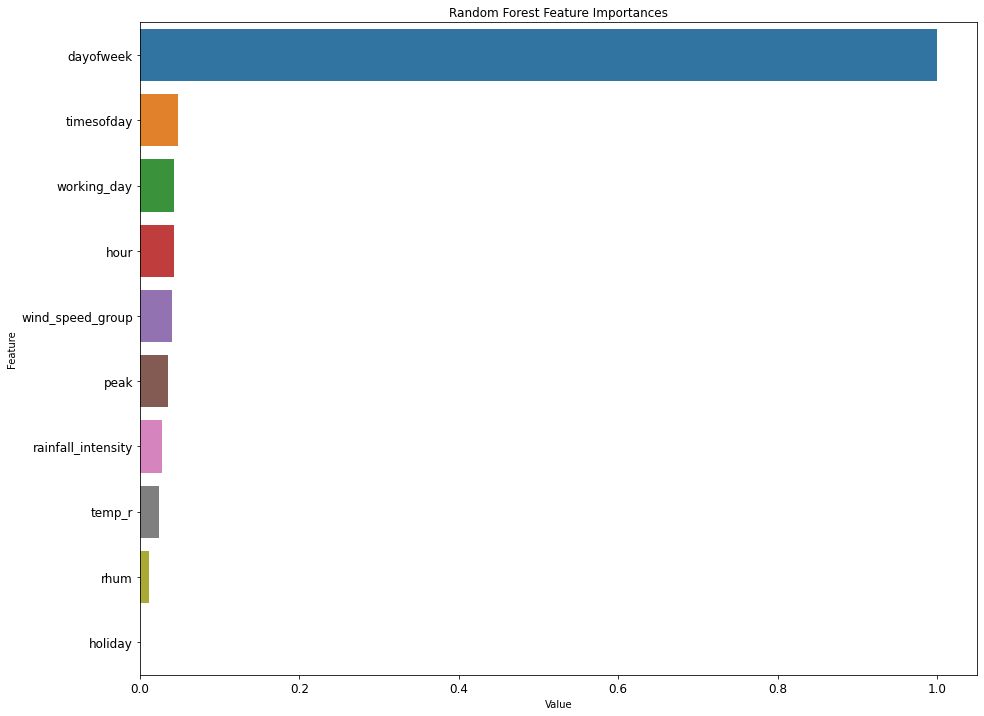

In [69]:
plot_feature_importances(pipe_rf['model'], predictors,'Random Forest Feature Importances')

In [ ]:
%%time

cv = KFold(n_splits=3, shuffle=True, random_state=2022)

for n_fold, (train_index, test_index) in enumerate(cv.split(X_train, y_train)):
    print('#'*40, f'Fold {n_fold+1} out of {cv.n_splits}', '#'*40)
    
    # X_train, y_train = X[train_index], y[train_index] # Train data
    # X_val, y_val = X[test_index], y[test_index] # Valid data
    
    # pipe_gbm.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)],
    #           verbose=250, early_stopping_rounds=50)
    
    # preds_lgb[test_index] += pipe_gbm.predict(X_val, raw_score=False)

## Catboost

In [ ]:
# Catboost model
# Fit a pipeline with transformers and an estimator to the training data
# pipe_catboost = Pipeline([
#     ('preprocessor', preprocessor),
#     ('model', CatBoostRegressor(verbose=1, n_estimators=100))
# ])
catboost_model = CatBoostRegressor(n_estimators=5000, depth=3, learning_rate=0.01, loss_function='RMSE')
catboost_model.fit(X_train, y_train, cat_features=predictors, eval_set=(X_test, y_test), verbose=250, early_stopping_rounds=30)

In [ ]:
y_test_pred = catboost_model.predict(df_test[predictors])
y_hat = pd.DataFrame(y_test_pred, columns=['count'])

In [ ]:
metrics.mean_absolute_error(y_test, y_test_pred)

## Feature Importance

In [ ]:
# LightGBM model
params_lightgbm = {'n_estimators': 5000,
                   'objective': 'l1',
                   'learning_rate': 0.01, 
                   'subsample': 0.7,
                   'verbosity': -1,
                   'feature_fraction': 0.5,
                   'bagging_fraction': 0.5,
                   'bagging_freq': 20,
                   'importance_type': 'gain'
                   }

# Fit a pipeline with transformers and an estimator to the training data
pipe_gbm = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LGBMRegressor(**params_lightgbm))
])
pipe_gbm.fit(X_train, y_train)

#Plotting features importance
feature_imp = pd.DataFrame(sorted(zip(pipe_gbm['model'].feature_importances_,X_train.columns)), 
                           columns=['Value','Feature'])
scaler_ft = MinMaxScaler()
feature_imp['Value'] = scaler_ft.fit_transform(feature_imp['Value'].values.reshape(-1,1));

fig = plt.figure(figsize=(15, 12))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features Importance')
locs, labels = plt.xticks()
plt.tick_params(axis='both', which='major', labelsize=12)

plt.show()

## Random Forest Regressor

### Extrapolation problem 

When using a Random Forest Regressor, the predicted values are never outside the training set values for the target variable. If it is tasked with the problem of predicting for values not previously seen, it will always predict an average of the values seen previously. Obviously the average of a sample can not fall outside the highest and lowest values in the sample. 

The Random Forest Regressor is unable to discover trends that would enable it in extrapolating values that fall outside the training set. When faced with such a scenario, the regressor assumes that the prediction will fall close to the maximum value in the training set. 


### Potential solutions

Ok, so how can you deal with this extrapolation problem?

There are a couple of options:

- Use a linear model such as SVM regression, Linear Regression, etc
- Build a deep learning model because neural nets are able to extrapolate (they are basically stacked linear regression models on steroids)
- Combine predictors using [stacking](https://scikit-learn.org/stable/auto_examples/ensemble/plot_stack_predictors.html). For example, you can create a stacking regressor using a Linear model and a Random Forest Regressor. 
- Use modified versions of random forest

One of such extensions is [Regression-Enhanced Random Forests](https://arxiv.org/pdf/1904.10416.pdf) (RERFs). The authors of this paper propose a technique borrowed from the strengths of penalized parametric regression to give better results in extrapolation problems.

Specifically, there are two steps to the process:

run Lasso before Random Forest, 
train a Random Forest on the residuals from Lasso. 
Since Random Forest is a fully nonparametric predictive algorithm, it may not efficiently incorporate known relationships between the response and the predictors. The response values are the observed values Y1, . . . , Yn  from the training data. RERFs are able to incorporate known relationships between the responses and the predictors which is another benefit of using Regression-Enhanced Random Forests for regression problems.

Source: https://neptune.ai/blog/random-forest-regression-when-does-it-fail-and-why

In [ ]:
# random forest model
params_rf = {'n_estimators': 1000, 
             'max_depth': 20, 
             'random_state': 0, 
             'min_samples_split' : 5,
             'n_jobs': -1}

# Fit a pipeline with transformers and an estimator to the training data
pipe_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(**params_rf, criterion='mae'))
])
pipe_rf.fit(X_train, y_train)

In [ ]:
pipe_rf['model'].feature_importances_

In [ ]:
#Plotting features importance
feature_imp = pd.DataFrame(sorted(zip(pipe_rf['model'].feature_importances_,X_train.columns)), 
                           columns=['Value','Feature'])
scaler_ft = MinMaxScaler()
feature_imp['Value'] = scaler_ft.fit_transform(feature_imp['Value'].values.reshape(-1,1));

fig = plt.figure(figsize=(15, 12))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Random Forest Features Importance')
locs, labels = plt.xticks()
plt.tick_params(axis='both', which='major', labelsize=12)

plt.show()

In [ ]:
from sklearn.inspection import permutation_importance
import shap

In [ ]:
perm_importance = permutation_importance(pipe_rf, X_test, y_test)

In [ ]:
perm_importance

In [ ]:
sorted_idx = perm_importance.importances_mean.argsort()
sorted_idx
# plt.barh(feature_imp[sorted_idx], perm_importance.importances_mean[sorted_idx])
# plt.xlabel("Permutation Importance")

In [ ]:
# random forest model
params_rf = {'n_estimators': 1000, 
             'max_depth': 20, 
             'random_state': 0, 
             'min_samples_split' : 5,
             'n_jobs': -1}

# Fit a pipeline with transformers and an estimator to the training data
pipe_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(**params_rf, criterion='mae'))
])
pipe_rf.fit(X_train, y_train)

#Plotting features importance
feature_imp = pd.DataFrame(sorted(zip(pipe_gbm['model'].feature_importances_,X_train.columns)), 
                           columns=['Value','Feature'])
scaler_ft = MinMaxScaler()
feature_imp['Value'] = scaler_ft.fit_transform(feature_imp['Value'].values.reshape(-1,1));

fig = plt.figure(figsize=(15, 12))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Random Forest Features Importance')
locs, labels = plt.xticks()
plt.tick_params(axis='both', which='major', labelsize=12)

plt.show()

In [ ]:
# random forest model
params_rf = {'n_estimators': 1000, 
             'max_depth': 20, 
             'random_state': 0, 
             'min_samples_split' : 5, 
             'n_jobs': -1}

# Fit a pipeline with transformers and an estimator to the training data
pipe_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(**params_rf))
])
pipe_rf.fit(X_train, y_train)
# y_train_pred = pipe_rf.predict(X_train)
# y_test_pred = pipe_rf.predict(X_test)

# print_evalmetrics(y_test, y_test_pred)

## Support Vector Regression

In [ ]:
from sklearn.svm import SVR

# Fit a pipeline with transformers and an estimator to the training data
pipe_svr = Pipeline([
    ('preprocessor', preprocessor),
    ('model', SVR(kernel='poly',gamma='scale',C=100))
])
pipe_svr.fit(X_train, y_train)
y_train_pred = pipe_svr.predict(X_train)
y_test_pred = pipe_svr.predict(X_test)

print_evalmetrics(y_test, y_test_pred)

In [ ]:
from numpy import mean
from numpy import std
from numpy import absolute
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# define the model cross-validation configuration
cv = KFold(n_splits=10, shuffle=True, random_state=1)
# evaluate the pipeline using cross validation and calculate MAE
scores = cross_val_score(pipe_svr, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# convert MAE scores to positive values
scores = absolute(scores)
# summarize the model performance
print('MAE: %.3f (%.3f)' % (mean(scores), std(scores)))
y_test_pred = pipe_svr.predict(X_test)
print_evalmetrics(y_test, y_test_pred)

In [ ]:
predicted_values = pd.DataFrame()
predicted_values['real'] = y_test
predicted_values['predicted'] = y_test_pred

predicted_values

## GradientBoost

In [ ]:
# GBM model
params_gbm = {'n_estimators': 150, 
              'max_depth': 5, 
              'random_state': 0, 
              'min_samples_leaf' : 10, 
              'learning_rate': 0.01, 
              'subsample': 0.7, 
              'loss': 'ls'}

# Fit a pipeline with transformers and an estimator to the training data
pipe_gbm = Pipeline([
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(**params_gbm))
])
pipe_gbm.fit(X_train, y_train)
y_train_pred = pipe_gbm.predict(X_train)
y_test_pred = pipe_gbm.predict(X_test)

print_evalmetrics(y_test, y_test_pred)

## LightGBM

In [ ]:
# LightGBM model
params_lightgbm = {'n_estimators': 1000, 
                   'max_depth': 15, 
                   'random_state': 0, 
                   'learning_rate': 0.01, 
                   'subsample': 0.7,
                   'num_leaves': 30,
                   'metric': 'rmse',
                   'n_jobs': 2
                   }

# Fit a pipeline with transformers and an estimator to the training data
pipe_gbm = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LGBMRegressor(**params_lightgbm))
])
pipe_gbm.fit(X_train, y_train)
y_train_pred = pipe_gbm.predict(X_train)
y_test_pred = pipe_gbm.predict(X_test)

print_evalmetrics(y_test, y_test_pred)

In [ ]:
%reload_ext watermark
%watermark -a "Leandro Pessini" -n -u -v -iv -w

<img title="GitHub Mark" src="./img/GitHub-Mark-64px.png" style="height: 32px; padding-right: 15px" alt="GitHub Mark" align="left"> [GitHub repository](https://github.com/pessini/moby-bikes) <br>Author: Leandro Pessini